In [1]:
import json
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt, cm

In [2]:
mini_json_filename = 'results_20210718/ph5_19-003_example/miniPH5_00001_ref_fs.json'

In [3]:
def not_data_key(key : str) -> bool:
    """
    This function looks for if a key is a known .zXXX and if so returns true
    :param key: dict key from reference json
    :return: Boolean true if is a known zarr key
    """
    is_zattrs = key.endswith('.zattrs')
    is_zarray = key.endswith('.zarray')
    is_zgroup = key.endswith('.zgroup')
    return is_zattrs or is_zarray or is_zgroup

In [4]:
fp = open(mini_json_filename)
mini_json = json.load(fp)
fp.close()

In [5]:
def walk_dict(d: dict, key_filt):
    rtn_d = {}
    for k, v in d.items():
        if key_filt(k):
            continue # filter value by not returning
        if isinstance(v, dict):
            sub_dict = walk_dict(v, key_filt)
            if len(sub_dict) > 0: # only assign if this subdict was not empty
                rtn_d.setdefault(k, sub_dict)
        else:
            rtn_d.setdefault(k, v)

    return rtn_d

data_dict = walk_dict(mini_json, not_data_key)

In [6]:
df = pd.DataFrame(data_dict['refs'])
df = df.transpose()
df = df.reset_index()
df.columns = ['path', 'prefix', 'offset', 'size']

In [7]:
split_key = df['path'].str.split('/')
# IMPROVE handling if data is not at the same depth of path (n*'/')
key_df = pd.DataFrame(split_key.to_list()) # convert to 2D df

df['das_name'] = key_df[2].to_numpy()
df['data_name'] = key_df[3].to_numpy()
df['chunk_num'] = key_df[4].to_numpy()
df

,path,prefix,offset,size,das_name,data_name,chunk_num
0,Experiment_g/Maps_g/Das_g_1X101/Hdr_a_0001/0,{{u}},1986632,2694,Das_g_1X101,Hdr_a_0001,0
1,Experiment_g/Maps_g/Das_g_1X101/Hdr_a_0002/0,{{u}},9400674,2911,Das_g_1X101,Hdr_a_0002,0
2,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},103968,34386,Das_g_1X101,Data_a_0001,0
3,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},138354,34273,Das_g_1X101,Data_a_0001,1
4,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},446154,34082,Das_g_1X101,Data_a_0001,10
...,...,...,...,...,...,...,...
327,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},9400579,95,Das_g_1X101,Data_a_0006,54
328,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},8385343,33087,Das_g_1X101,Data_a_0006,6
329,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},8418430,32742,Das_g_1X101,Data_a_0006,7
330,Experiment_g/Receivers_g/Das_g_1X101/Data_a_00...,{{u}},8451172,33001,Das_g_1X101,Data_a_0006,8


In [8]:
df.groupby('data_name')['size'].sum()

data_name
Data_a_0001    1879640
Data_a_0002    1244348
Data_a_0003    1876519
Data_a_0004    1243070
Data_a_0005    1820589
Data_a_0006    1211238
Hdr_a_0001        2694
Hdr_a_0002        2911
Name: size, dtype: object

In [9]:
df['size'].sum()

9281009

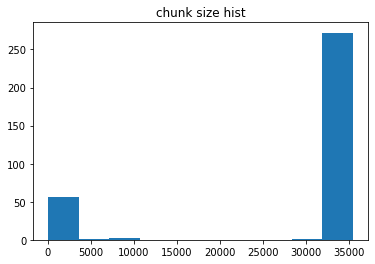

In [10]:
df.describe()
# df.plot.hist('size', 100)
plt.hist(df['size'])
plt.title('chunk size hist')
min_size = df['size'].min()

In [11]:
# create intervals
frag_df = pd.DataFrame({'data_name' : df.data_name,
                        'das_name' : df.das_name,
                        'start' : df['offset'],
                        'end' : df['offset']+df['size']
                        })

In [12]:
# create intervals
# df_iv = pd.Interval(left=frag_df['start'], right=frag_df['right'])
# create_iv_per_row = lambda row: pd.Interval(row['start'], row['end'])
# TODO check if closure i.e. inclusions are reasonable
# frag_df['iv'] = frag_df.apply(create_iv_per_row, axis=1)

# Better way
# frag_df['iv'] = pd.IntervalIndex.from_arrays(left=frag_df['start'], right=frag_df['end'])
frag_iv_idx = pd.IntervalIndex.from_arrays(left=frag_df['start'], right=frag_df['end'])
frag_df['iv'] = frag_iv_idx

# TODO figure out what is overlapping
no_overlap = frag_iv_idx.is_non_overlapping_monotonic

# TODO check for overlaps
# pandas.IntervalIndex.is_non_overlapping_monotonic

In [13]:
df['size'].min()

84

In [14]:
# create n x m of 10K blocks
FRAG_BIN_SIZE = 10e3 # 10k bytes
n_cols = 16
max_byte = frag_df['end'].max()
n_blocks = math.ceil(max_byte / FRAG_BIN_SIZE)
n_rows = math.ceil(n_blocks / n_cols)
blocks = np.zeros(shape = [n_rows, n_cols])

In [15]:
data_names = frag_df['data_name'].unique()
color_enum = list(enumerate(data_names, start=1))
for color_n, name in color_enum:
    # frag_df.loc(frag_df['data_name'] == name)['data_color']
    frag_df.loc[frag_df['data_name'] == name, 'data_color']= color_n

In [16]:
block_iv = pd.interval_range(start=0, end=max_byte, freq=10e3)

# test = block_iv[100].overlaps(frag_iv_idx)
overlaps_idx = frag_iv_idx.overlaps(block_iv[0])
test = frag_df[overlaps_idx]['data_color']
a = test.mode().get(0, np.nan)

# block_iv.apply(block_iv.overlaps, frag_df['iv'])
color_blocks = block_iv.map(lambda x: frag_df.loc[frag_iv_idx.overlaps(x), 'data_color'].mode().get(0, np.nan))

In [17]:
c = color_blocks.to_numpy()
c_resize = np.resize(c, n_rows*n_cols) # add filler at the end to make it rectangular
c_reshaped = c_resize.reshape((n_rows, n_cols,))

[Text(1, 0, 'None'),
 Text(1, 1, 'Hdr_a_0001'),
 Text(1, 2, 'Hdr_a_0002'),
 Text(1, 3, 'Data_a_0001'),
 Text(1, 4, 'Data_a_0002'),
 Text(1, 5, 'Data_a_0003'),
 Text(1, 6, 'Data_a_0004'),
 Text(1, 7, 'Data_a_0005'),
 Text(1, 8, 'Data_a_0006')]

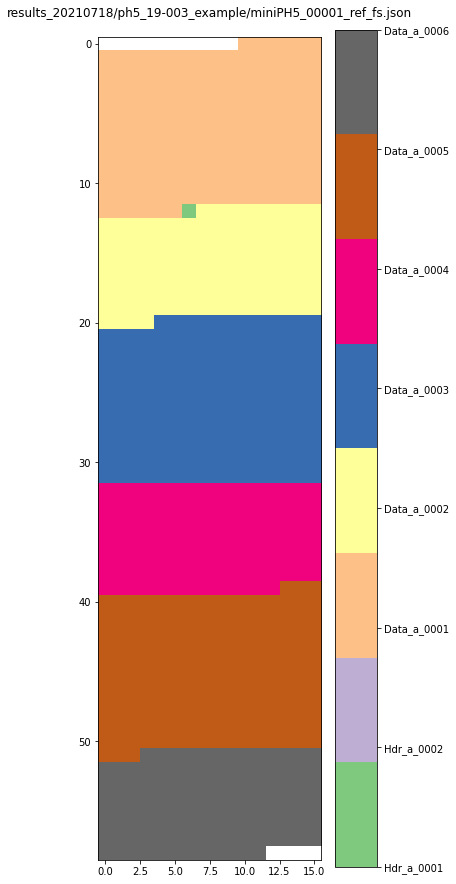

In [18]:
fig, ax = plt.subplots(figsize = (5, 50))

cax = ax.imshow(c_reshaped, cmap=cm.Accent)
ax.set_title(mini_json_filename, pad=20)
#
# # Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=range(0,9))
cbar.ax.set_yticklabels(['None', *data_names])  # vertically oriented colorbar
